In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=6e8fe000ae2e8c60ba2c57a13ac447c34afbdafb9d57bfaad393be6d7d6bbe05
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 12.8 GB  |     Proc size: 119.3 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total     11441MB


In [ ]:
!nvidia-smi

Tue Dec  7 04:38:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pandas as pd
import numpy as np
import random
import codecs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import naive_bayes, svm
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
import pickle
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Load the data set

---


obtained from: https://conservancy.umn.edu/handle/11299/137703

In [ ]:
# read txt file (save the file with utf-8 encoding on visual studio)
column=['short_form','long_form','represent_in_st','pos_start','pos_end','section','compt_st']
f = codecs.open("AnonymizedClinicalAbbreviationsAndAcronymsDataSet_encoded.txt", "r", "utf-8")
dt = pd.read_csv(f, sep='[|]', names=column, keep_default_na=False, na_values=['', 'null'])
#dt=pd.read_csv('AnonymizedClinicalAbbreviationsAndAcronymsDataSet.txt',sep='|',names=column, encoding='ISO-8859-1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [ ]:
dt.head(100)
#dt.drop(1649)
# dt = dt.drop([dt.index[1649]])
#dt.info()

,short_form,long_form,represent_in_st,pos_start,pos_end,section,compt_st
0,AB,abortion,AB.,231,233,NaN,_%#NAME#%_ _%#NAME#%_ is a 29-year-old gravida...
1,AB,abortion,AB.,249,251,NaN,She is now bleeding quite heavily. Ultrasound ...
2,AB,abortion,AB,223,224,PAST OB HISTORY,ALLERGIES: Heparin and Imitrex. PAST OB HISTOR...
3,AB,abortion,AB.,194,196,HISTORY OF THE PRESENT ILLNESS,She had a pelvic ultrasound at Park Nicollet o...
4,AB,abortion,AB,114,115,PAST OB-GYN HISTORY,"On _%#MMDD2007#%_, normal anatomy with anterio..."
...,...,...,...,...,...,...,...
95,AB,abortion,AB,63,64,NaN,_%#NAME#%_ _%#NAME#%_ is a 56-year-old female ...
96,AB,abortion,AB,65,66,NaN,_%#NAME#%_ _%#NAME#%_ is a 30-year-old teacher...
97,AB,abortion,AB,250,251,OB HISTORY,"She received RhoGAM on _%#MM#%_ _%#DD#%_, 2006..."
98,AB,blood group in ABO system,AB,162,163,PRENATAL LABORATORY,CURRENT MEDICATIONS: Prenatal vitamins. ALLERG...


In [ ]:
dt['long_form'].value_counts()

idiopathic thrombocytopenic purpura    500
Narcotics Anonymous                    474
(stage) IB                             472
extra strength                         469
over the counter                       469
                                      ... 
(drug) DC                                1
enterocutaneous:EC                       1
(PO Box) C4                              1
creatine phosphokinase:CPK               1
retinoic acid                            1
Name: long_form, Length: 351, dtype: int64

# Observe the data

In [ ]:
dt.head(2)

,short_form,long_form,represent_in_st,pos_start,pos_end,section,compt_st
0,AB,abortion,AB.,231,233,NaN,_%#NAME#%_ _%#NAME#%_ is a 29-year-old gravida...
1,AB,abortion,AB.,249,251,NaN,She is now bleeding quite heavily. Ultrasound ...


In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   short_form       37500 non-null  object
 1   long_form        37500 non-null  object
 2   represent_in_st  37500 non-null  object
 3   pos_start        37500 non-null  int64 
 4   pos_end          37500 non-null  int64 
 5   section          36479 non-null  object
 6   compt_st         37500 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.0+ MB


In [ ]:
dt.loc[dt['section'].isnull(), :]

,short_form,long_form,represent_in_st,pos_start,pos_end,section,compt_st
0,AB,abortion,AB.,231,233,NaN,_%#NAME#%_ _%#NAME#%_ is a 29-year-old gravida...
1,AB,abortion,AB.,249,251,NaN,She is now bleeding quite heavily. Ultrasound ...
9,AB,abortion,AB,65,66,NaN,_%#NAME#%_ _%#NAME#%_ is a 25-year-old female ...
22,AB,abortion,AB,66,67,NaN,"_%#NAME#%_ _%#NAME#%_ is a 40-year-old female,..."
23,AB,abortion,AB,65,66,NaN,"_%#NAME#%_ _%#NAME#%_ is a 40-year-old female,..."
...,...,...,...,...,...,...,...
37396,VAD,ventricular assist device,VAD,255,257,NaN,This has led to a sense of needing to vomit an...
37438,VAD,vincristine adriamycin and dexamethasone,VAD,215,217,NaN,He was hospitalized _%#MM#%_ _%#DD#%_ to _%#MM...
37443,VAD,ventricular assist device,VAD,152,154,NaN,His PA pressures have improved significantly f...
37444,VAD,ventricular assist device,VAD,144,146,NaN,His BP is stable and has required NTG for bett...


In [ ]:
# identify if if this data is unbalanced.
dt['long_form'].value_counts()

idiopathic thrombocytopenic purpura    500
Narcotics Anonymous                    474
(stage) IB                             472
extra strength                         469
over the counter                       469
                                      ... 
(drug) DC                                1
enterocutaneous:EC                       1
(PO Box) C4                              1
creatine phosphokinase:CPK               1
retinoic acid                            1
Name: long_form, Length: 351, dtype: int64

Since the long form is our labels, we first test if there are any inbalance in the data. Since there are many labels only shows once, and we try to avoid the inbalance data, we set the threshold to use the labels are 125. (The most frequency lebels has 500 records, we try to keey (80:20) ratio.

In [ ]:
# build filter for the label:
label_dict = dt['long_form'].value_counts().to_dict()
filtered_label_dict = [key for key, value in label_dict.items() if value > 125]
filtered_label_dict[:5]

['idiopathic thrombocytopenic purpura',
 'Narcotics Anonymous',
 '(stage) IB',
 'extra strength',
 'over the counter']

In [ ]:
# keey only labels that have over 125 records 
dt = dt[dt['long_form'].isin(filtered_label_dict)]

In [ ]:
dt=dt.reset_index(drop=True)
#add id column
dt['id'] = dt.index

In [ ]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32566 entries, 0 to 32565
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   short_form       32566 non-null  object
 1   long_form        32566 non-null  object
 2   represent_in_st  32566 non-null  object
 3   pos_start        32566 non-null  int64 
 4   pos_end          32566 non-null  int64 
 5   section          31787 non-null  object
 6   compt_st         32566 non-null  object
 7   id               32566 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 2.0+ MB


In [ ]:
#possible long_form format 1
long_form_lst=dt['long_form'].unique().tolist()
dic_long={}
i=0
for word in long_form_lst:
  dic_long[word]=i
  i=i+1
print(dic_long)


{'abortion': 0, 'blood group in ABO system': 1, 'UNSURED SENSE': 2, 'vertical banded gastroplasty': 3, 'venous blood gas': 4, '(drug) AC': 5, 'acromioclavicular': 6, 'ad lib on demand': 7, 'against medical advice': 8, 'acetylsalicylic acid': 9, 'aortic valve replacement': 10, 'atrioventricular': 11, 'bronchoalveolar lavage': 12, 'BK (virus)': 13, 'below knee': 14, 'basic metabolic profile': 15, 'bowel movement': 16, 'conjunctivae and sclerae': 17, 'cervical (level) 3': 18, '(complement) component 3': 19, 'cervical (level) 4': 20, '(complement) component 4': 21, 'cancer': 22, 'center for diagnostic imaging': 23, "Children's Depression Inventory": 24, 'carcinoembryonic antigen': 25, 'controlled release': 26, 'clear to auscultation': 27, 'costovertebral angle': 28, 'cerebrovascular accident': 29, 'central venous pressure': 30, 'chorionic villus sampling': 31, 'direct current': 32, 'discontinue': 33, 'distal interphalangeal': 34, 'dextromethorphan': 35, 'diabetes mellitus': 36, 'diphtheria

In [ ]:
dt['long_form_id'] = dt['long_form'].replace(dic_long)
#dt.head()

In [ ]:
dt.columns

Index(['short_form', 'long_form', 'represent_in_st', 'pos_start', 'pos_end',
       'section', 'compt_st', 'id', 'long_form_id'],
      dtype='object')

In [ ]:
# function Replace represent_in_st to short form to prevent any special character in the short form like M.O.M. to MOM
replace_list = ["compt_st", "represent_in_st", "short_form"]
replace_index_list = [dt.columns.get_loc(c) for c in replace_list if c in dt]
def adv_clean(df, replace_index_list=replace_index_list):
  full_sentenct = df[replace_index_list[0]]
  short_form_represent = df[replace_index_list[1]]
  short_form = df[replace_index_list[2]]
  clean_short_form_sentence = full_sentenct.replace(short_form_represent, short_form)
  return clean_short_form_sentence

In [ ]:
#Text cleaning (keep all special character )
stop = stopwords.words('english')
dt['clean_compt_st']=dt.apply(adv_clean, axis=1)
#delete all nums in string of the dataframe
dt['clean_compt_st'] = dt['clean_compt_st'].str.replace(r'\b[0-9]+\b\s*', ' ')
dt['clean_compt_st'] = dt['clean_compt_st'].str.replace('[^a-zA-Z1-9&]', ' ')
de_identify_list=['mmdd','name','street','city','country','prectinct','address','55400','00000','ddmm2000','mm','dd','2000','ddmm1914','tel','fax','email','ssn','mrn','hpbn','accountn','ln','vn','device']
remove = stop # change the code
pat = r'\b(?:{})\b'.format('|'.join(remove))
dt['clean_compt_st'] = dt['clean_compt_st'].str.replace(pat, '    ')
dt['clean_compt_st'] = dt['clean_compt_st'].str.replace('\s+', ' ', regex=True)
dt['clean_compt_st']=dt['clean_compt_st'].str.lower()
#dt.head()

In [ ]:
dt.loc[dt['represent_in_st'] == 'V.B.G.',:]

,short_form,long_form,represent_in_st,pos_start,pos_end,section,compt_st,id,long_form_id,clean_compt_st
653,VBG,venous blood gas,V.B.G.,128,133,PROBLEM #4,We thought that tracheomalacia might be playin...,653,4,we thought tracheomalacia might playing role s...


In [ ]:
dt['represent_in_st'].value_counts()[400:435]

T1:        1
(PDA).     1
(SBP       1
VBG;       1
O.P        1
(GT).      1
(SS)       1
ER),       1
(SBP).     1
PE:        1
(PDA),     1
(IR        1
P.C.P.     1
(ALD)      1
(SA)       1
SBP;       1
PCP;       1
(AVR),     1
LE:        1
MR;        1
(PA        1
BAL)       1
L.A.       1
(NP),      1
(DIP),     1
(MP        1
(CVS       1
(OTC)      1
(OR        1
(IM)       1
2)LE       1
A.S.A.,    1
PAC;       1
R.A.       1
(VAD),     1
Name: represent_in_st, dtype: int64

In [ ]:
pd.set_option('display.max_rows', 100)

#distill BERT with clean complete sentence, batch_size=8



In [ ]:
!pip install ktrain

In [ ]:
import sklearn.linear_model._base
import sys
sys.modules['sklearn.linear_model.base'] = sklearn.linear_model._base
import ktrain
from ktrain import text

In [ ]:
categories=pd.unique(dt['long_form_id'])
categories=list(set(categories))
categories

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101]

In [ ]:
from sklearn.model_selection import train_test_split

# Use 80% for training and 20% for validation.
X_train, X_test, y_train, y_test = train_test_split(dt['clean_compt_st'],dt['long_form_id'],stratify=dt['long_form_id'],
                                                            random_state=2018, test_size=0.2)

In [ ]:
model_name='distilbert-base-uncased'

In [ ]:
trans=text.Transformer(model_name, maxlen=512, class_names=categories)

In [ ]:
import numpy as np
X_train=X_train.to_list()
y_train=np.array(y_train)

X_test=X_test.to_list()
y_test=np.array(y_test)

In [ ]:
print(type(X_train))
print(type(y_train))
print(type(X_test))
print(type(y_test))

<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
model=trans.get_classifier()

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:429: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn('The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.')


In [ ]:
train_data=trans.preprocess_train(X_train, y_train)
test_data=trans.preprocess_test(X_test, y_test)

preprocessing train...
language: en
train sequence lengths:
	mean : 39
	95percentile : 56
	99percentile : 74


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 39
	95percentile : 57
	99percentile : 76


In [ ]:
learner=ktrain.get_learner(model,train_data=train_data,val_data=test_data, batch_size=8)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
3256/3256 [==============================] - 954s 288ms/step - loss: 4.5617 - accuracy: 0.0423
Epoch 2/5
3256/3256 [==============================] - 943s 290ms/step - loss: 1.7637 - accuracy: 0.7099
Epoch 3/5
3256/3256 [==============================] - 873s 268ms/step - loss: 3.7010 - accuracy: 0.1989


done.
Visually inspect loss plot and select learning rate associated with falling loss


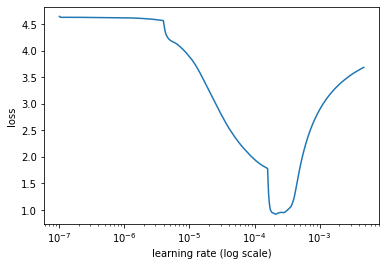

In [ ]:
learner.lr_find(show_plot=True,max_epochs=5)

In [ ]:
learner.fit_onecycle(1e-4,1)



begin training using onecycle policy with max lr of 0.0001...
3257/3257 [==============================] - 998s 305ms/step - loss: 1.2100 - accuracy: 0.7524 - val_loss: 0.1685 - val_accuracy: 0.9510


In [ ]:
res=learner.validate(class_names=categories)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        69
           1       1.00      0.96      0.98        27
           2       0.81      0.38      0.52        45
           3       0.95      1.00      0.98        60
           4       1.00      0.93      0.96        40
           5       0.97      1.00      0.98        32
           6       1.00      1.00      1.00        32
           7       0.99      1.00      0.99        81
           8       1.00      1.00      1.00        89
           9       1.00      0.91      0.95        81
          10       0.99      1.00      0.99        76
          11       0.99      0.99      0.99        75
          12       0.98      1.00      0.99        91
          13       0.99      1.00      0.99        69
          14       1.00      1.00      1.00        31
          15       1.00      0.95      0.97        91
          16       0.96      1.00      0.98        92
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
learner.view_top_losses(n=5,preproc=trans)

----------
id:6039 | loss:12.05 | true:66 | pred:94)

----------
id:4930 | loss:11.88 | true:53 | pred:13)

----------
id:6276 | loss:11.37 | true:9 | pred:59)

----------
id:1048 | loss:9.77 | true:45 | pred:62)

----------
id:5075 | loss:9.25 | true:39 | pred:92)



In [ ]:
X_test[6276]

' left total knee arthroplasty ovarian cyst removal age p cabg mmdd2 7 reviewed chart current inpatient med list outpatient med list nexium vicodin sensipar 3 mg qday phoslo 667mg tid renagel 8 mg tid hydroxyzine allegra gemfibrozil asa dialyvite lexapro seroquel flexeril sh smoking etoh abuse drugs fh non contributory pe vitals reviewed i o reviewed essentially anuric alert pleasant non toxic nad ncat conj icterus op clear neck supple nt cervical lad rrr left permcath site c d i cta non labored abdomens soft incision site c d i right av fistula per patient aneurysm resected repaired intra operatively trace edema le neuro non focal today labs reviewed a p year old female pod p ddkt dgfx likely due atn prolonged cold ischemia time '

In [ ]:
X_test[4930]

'suspect rejection could chronic changes unable schedule procedure ultrasound need ir will follow patient check ua urine protein creatinine ratio check cmv bk virus check renal ultrasound dopplers i present participated evaluation agree fellow note name '

In [ ]:
X_test[1048]

' she asked follow nurse practitioner week she continue cardiac rehab fairview ridges hospital we consider mr lipoprotein profile assess ldl particle number well size i would also consider lipoprotein evaluated ldl less '

In [ ]:
# setup a predict for future sentence input
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [ ]:
x='i love eating fish'
predictor.predict(x)

45

In [ ]:
learner.evaluate(class_names=categories, save_path='ktrain_classification_report.csv', print_report=False)

classification report saved to: ktrain_classification_report.csv


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[66,  0,  0, ...,  0,  0,  0],
       [ 1, 26,  0, ...,  0,  0,  0],
       [ 0,  0, 17, ...,  0,  1,  1],
       ...,
       [ 0,  0,  0, ..., 64,  0,  0],
       [ 0,  0,  0, ...,  0, 80,  0],
       [ 0,  0,  0, ...,  0,  0, 79]])

In [ ]:
ktrain_classification_column=['long_form_id','precision','recall','f1-score	','support']
ktrain_classification_report = pd.read_csv('ktrain_classification_report.csv', names = ktrain_classification_column, skiprows=1)

In [ ]:
new_dict

{0: 'abortion',
 1: 'blood group in ABO system',
 2: 'UNSURED SENSE',
 3: 'vertical banded gastroplasty',
 4: 'venous blood gas',
 5: '(drug) AC',
 6: 'acromioclavicular',
 7: 'ad lib on demand',
 8: 'against medical advice',
 9: 'acetylsalicylic acid',
 10: 'aortic valve replacement',
 11: 'atrioventricular',
 12: 'bronchoalveolar lavage',
 13: 'BK (virus)',
 14: 'below knee',
 15: 'basic metabolic profile',
 16: 'bowel movement',
 17: 'conjunctivae and sclerae',
 18: 'cervical (level) 3',
 19: '(complement) component 3',
 20: 'cervical (level) 4',
 21: '(complement) component 4',
 22: 'cancer',
 23: 'center for diagnostic imaging',
 24: "Children's Depression Inventory",
 25: 'carcinoembryonic antigen',
 26: 'controlled release',
 27: 'clear to auscultation',
 28: 'costovertebral angle',
 29: 'cerebrovascular accident',
 30: 'central venous pressure',
 31: 'chorionic villus sampling',
 32: 'direct current',
 33: 'discontinue',
 34: 'distal interphalangeal',
 35: 'dextromethorphan',
 

In [ ]:
ktrain_classification_report_1 = ktrain_classification_report.iloc[:102,:]

In [ ]:
ktrain_classification_report_1 = ktrain_classification_report_1.astype({'long_form_id': 'int64'})

In [ ]:
ktrain_classification_report_1['long_form'] = ktrain_classification_report_1['long_form_id'].replace(new_dict)


In [ ]:
ktrain_classification_report_1

,long_form_id,precision,recall,f1-score\t,support,long_form
0,0,0.985075,0.956522,0.970588,69.0,abortion
1,1,1.000000,0.962963,0.981132,27.0,blood group in ABO system
2,2,0.809524,0.377778,0.515152,45.0,UNSURED SENSE
3,3,0.952381,1.000000,0.975610,60.0,vertical banded gastroplasty
4,4,1.000000,0.925000,0.961039,40.0,venous blood gas
...,...,...,...,...,...,...
97,97,0.702703,0.962963,0.812500,54.0,triiodothyronine
98,98,0.810811,0.967742,0.882353,31.0,tumor stage 3
99,99,0.955224,0.752941,0.842105,85.0,thyroxine
100,100,0.930233,1.000000,0.963855,80.0,United States


In [ ]:
ktrain_classification_report_1.sort_values(by='f1-score\t')

,long_form_id,precision,recall,f1-score\t,support,long_form
38,38,0.000000,0.000000,0.000000,26.0,delirium tremens
21,21,0.600000,0.065217,0.117647,46.0,(complement) component 4
78,78,0.909091,0.357143,0.512821,28.0,patent ductus arteriosus
2,2,0.809524,0.377778,0.515152,45.0,UNSURED SENSE
19,19,0.527473,0.979592,0.685714,49.0,(complement) component 3
...,...,...,...,...,...,...
8,8,1.000000,1.000000,1.000000,89.0,against medical advice
60,60,1.000000,1.000000,1.000000,88.0,multiples of median
6,6,1.000000,1.000000,1.000000,32.0,acromioclavicular
31,31,1.000000,1.000000,1.000000,91.0,chorionic villus sampling


#distill BERT with unclean complete sentence, batch_size=8



     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 6.8 MB 31.0 MB/s 
     |████████████████████████████████| 981 kB 57.9 MB/s 
     |████████████████████████████████| 263 kB 51.5 MB/s 
     |████████████████████████████████| 2.8 MB 73.0 MB/s 
     |████████████████████████████████| 1.2 MB 45.0 MB/s 
     |████████████████████████████████| 468 kB 68.4 MB/s 
     |████████████████████████████████| 61 kB 573 kB/s 
     |████████████████████████████████| 895 kB 59.5 MB/s 
     |████████████████████████████████| 3.3 MB 62.5 MB/s 
     |████████████████████████████████| 596 kB 59.8 MB/s 
  Created wheel for ktrain: filename=ktrain-0.28.3-py3-none-any.whl size=25292659 sha256=b99be468ed30cb78016c3c05d226e49b38ee2714cd144e886cb1f9aa08d45901
  Stored in directory: /root/.cache/pip/wheels/6a/7e/c3/f46cdfc2b81c54424923b1405d7e670c35cacc11ada9a47b1c
  Created wheel for seqeval: filename=seqeval-0.0.19-py3-none-any.whl size=9929 sha256=fbc5e0d039765b9c

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:429: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn('The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.')


Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 60
	95percentile : 87
	99percentile : 111


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 60
	95percentile : 87
	99percentile : 111


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
3256/3256 [==============================] - 954s 288ms/step - loss: 4.5556 - accuracy: 0.0461
Epoch 2/5
3256/3256 [==============================] - 942s 289ms/step - loss: 1.7632 - accuracy: 0.7347
Epoch 3/5
3256/3256 [==============================] - 585s 180ms/step - loss: 3.4838 - accuracy: 0.2398


done.
Visually inspect loss plot and select learning rate associated with falling loss


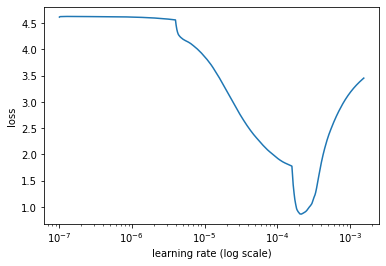

In [ ]:
!pip install ktrain
import sklearn.linear_model._base
import sys
sys.modules['sklearn.linear_model.base'] = sklearn.linear_model._base
import ktrain
from ktrain import text
categories=pd.unique(dt['long_form_id'])
categories=list(set(categories))
from sklearn.model_selection import train_test_split
# Use 80% for training and 20% for validation.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(dt['compt_st'],dt['long_form_id'],stratify=dt['long_form_id'],
                                                            random_state=2018, test_size=0.2)
model_name='distilbert-base-uncased'
trans=text.Transformer(model_name, maxlen=512, class_names=categories)
import numpy as np
X_train_2=X_train_2.to_list()
y_train_2=np.array(y_train_2)
X_test_2=X_test_2.to_list()
y_test_2=np.array(y_test_2)
model=trans.get_classifier()
train_data_2=trans.preprocess_train(X_train_2, y_train_2)
test_data_2=trans.preprocess_test(X_test_2, y_test_2)
learner_2=ktrain.get_learner(model,train_data=train_data_2,val_data=test_data_2, batch_size=8)
learner_2.lr_find(show_plot=True,max_epochs=5)

In [ ]:
learner_2.fit_onecycle(1e-4,1)



begin training using onecycle policy with max lr of 0.0001...
3257/3257 [==============================] - 1021s 310ms/step - loss: 1.1217 - accuracy: 0.7816 - val_loss: 0.1624 - val_accuracy: 0.9562


In [ ]:
learner_2.evaluate(class_names=categories, save_path='ktrain_classification_report_2.csv', print_report=False)

classification report saved to: ktrain_classification_report_2.csv


array([[68,  0,  0, ...,  0,  0,  0],
       [ 0, 27,  0, ...,  0,  0,  0],
       [ 0,  0, 14, ...,  0,  1,  1],
       ...,
       [ 1,  0,  0, ..., 68,  0,  0],
       [ 0,  0,  0, ...,  0, 80,  0],
       [ 0,  0,  0, ...,  0,  0, 79]])

In [ ]:
ktrain_classification_column=['long_form_id','precision','recall','f1-score	','support']
ktrain_classification_report = pd.read_csv('ktrain_classification_report_2.csv', names = ktrain_classification_column, skiprows=1)
new_dict = dict((v,k) for k,v in dic_long.items())
ktrain_classification_report_2 = ktrain_classification_report.iloc[:102,:]
ktrain_classification_report_2 = ktrain_classification_report_2.astype({'long_form_id': 'int64'})
ktrain_classification_report_2['long_form'] = ktrain_classification_report_2['long_form_id'].replace(new_dict)
ktrain_classification_report_2.head(101)

,long_form_id,precision,recall,f1-score\t,support,long_form
0,0,0.985507,0.985507,0.985507,69.0,abortion
1,1,1.000000,1.000000,1.000000,27.0,blood group in ABO system
2,2,0.875000,0.311111,0.459016,45.0,vertical banded gastroplasty
3,3,1.000000,0.983333,0.991597,60.0,venous blood gas
4,4,0.975610,1.000000,0.987654,40.0,(drug) AC
...,...,...,...,...,...,...
96,96,0.977778,0.977778,0.977778,45.0,96
97,97,0.757143,0.981481,0.854839,54.0,97
98,98,0.909091,0.967742,0.937500,31.0,98
99,99,0.957746,0.800000,0.871795,85.0,99


In [ ]:
#pd.set_option('display.max_rows', 120)

In [ ]:
ktrain_classification_report_2.sort_values(by='f1-score\t')

,long_form_id,precision,recall,f1-score\t,support,long_form
19,19,0.833333,0.102041,0.181818,49.0,cervical (level) 4
2,2,0.875000,0.311111,0.459016,45.0,vertical banded gastroplasty
21,21,0.500000,0.978261,0.661765,46.0,cancer
76,76,0.941176,0.592593,0.727273,27.0,Pneumocystis jiroveci pneumonia
78,78,0.947368,0.642857,0.765957,28.0,posterior descending artery
20,20,0.972222,0.673077,0.795455,52.0,(complement) component 4
38,38,0.766667,0.884615,0.821429,26.0,enteric-coated
94,94,0.709091,1.000000,0.829787,39.0,94
18,18,0.803571,0.900000,0.849057,50.0,(complement) component 3
97,97,0.757143,0.981481,0.854839,54.0,97


#distill BERT with unclean complete sentence -batchsize=16

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:429: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn('The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.')


preprocessing train...
language: en
train sequence lengths:
	mean : 60
	95percentile : 87
	99percentile : 111


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 60
	95percentile : 87
	99percentile : 111


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1628/1628 [==============================] - 886s 537ms/step - loss: 4.5818 - accuracy: 0.0310
Epoch 2/5
1628/1628 [==============================] - 880s 541ms/step - loss: 2.0540 - accuracy: 0.6619
Epoch 3/5
1628/1628 [==============================] - 788s 484ms/step - loss: 3.4677 - accuracy: 0.2419


done.
Visually inspect loss plot and select learning rate associated with falling loss


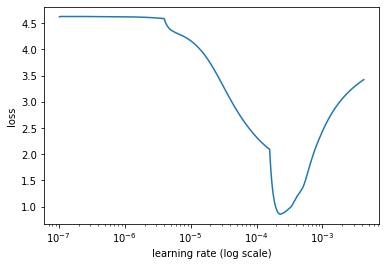

In [ ]:
!pip install ktrain
import sklearn.linear_model._base
import sys
sys.modules['sklearn.linear_model.base'] = sklearn.linear_model._base
import ktrain
from ktrain import text
categories=pd.unique(dt['long_form_id'])
categories=list(set(categories))
from sklearn.model_selection import train_test_split
# Use 80% for training and 20% for validation.
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(dt['compt_st'],dt['long_form_id'],stratify=dt['long_form_id'],
                                                            random_state=2018, test_size=0.2)
model_name='distilbert-base-uncased'
trans=text.Transformer(model_name, maxlen=512, class_names=categories)
import numpy as np
X_train_3=X_train_3.to_list()
y_train_3=np.array(y_train_3)
X_test_3=X_test_3.to_list()
y_test_3=np.array(y_test_3)
model=trans.get_classifier()
train_data_3=trans.preprocess_train(X_train_3, y_train_3)
test_data_3=trans.preprocess_test(X_test_3, y_test_3)
learner_3=ktrain.get_learner(model,train_data=train_data_3,val_data=test_data_3, batch_size=16)
learner_3.lr_find(show_plot=True,max_epochs=5)

In [ ]:
learner_3.fit_onecycle(1e-4,1)



begin training using onecycle policy with max lr of 0.0001...
1629/1629 [==============================] - 956s 579ms/step - loss: 1.3243 - accuracy: 0.7378 - val_loss: 0.1845 - val_accuracy: 0.9518


In [ ]:
learner_3.evaluate(class_names=categories, save_path='ktrain_classification_report_3.csv', print_report=False)

classification report saved to: ktrain_classification_report_3.csv


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  ----------
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  ----------
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  ----------


array([[69,  0,  0, ...,  0,  0,  0],
       [ 0, 27,  0, ...,  0,  0,  0],
       [ 0,  0, 17, ...,  0,  1,  1],
       ...,
       [ 0,  0,  0, ..., 68,  0,  0],
       [ 0,  0,  0, ...,  0, 80,  0],
       [ 0,  0,  0, ...,  0,  0, 79]])

In [ ]:
ktrain_classification_column=['long_form_id','precision','recall','f1-score	','support']
ktrain_classification_report_3 = pd.read_csv('ktrain_classification_report_3.csv', names = ktrain_classification_column, skiprows=1)
new_dict = dict((v,k) for k,v in dic_long.items())
ktrain_classification_report_3 = ktrain_classification_report_3.iloc[:102,:]
ktrain_classification_report_3 = ktrain_classification_report_3.astype({'long_form_id': 'int64'})
ktrain_classification_report_3['long_form'] = ktrain_classification_report_3['long_form_id'].replace(new_dict)
ktrain_classification_report_3.head(101)

,long_form_id,precision,recall,f1-score\t,support,long_form
0,0,1.000000,1.000000,1.000000,69.0,abortion
1,1,0.931034,1.000000,0.964286,27.0,blood group in ABO system
2,2,0.850000,0.377778,0.523077,45.0,UNSURED SENSE
3,3,0.983607,1.000000,0.991736,60.0,vertical banded gastroplasty
4,4,1.000000,0.950000,0.974359,40.0,venous blood gas
...,...,...,...,...,...,...
96,96,0.931818,0.911111,0.921348,45.0,T2 (MRI)
97,97,0.750000,0.944444,0.836066,54.0,triiodothyronine
98,98,0.937500,0.967742,0.952381,31.0,tumor stage 3
99,99,0.931507,0.800000,0.860759,85.0,thyroxine


In [ ]:
ktrain_classification_report_3.sort_values(by='f1-score\t')

,long_form_id,precision,recall,f1-score\t,support,long_form
38,38,0.000000,0.000000,0.000000,26.0,delirium tremens
78,78,1.000000,0.071429,0.133333,28.0,patent ductus arteriosus
19,19,0.875000,0.142857,0.245614,49.0,(complement) component 3
2,2,0.850000,0.377778,0.523077,45.0,UNSURED SENSE
21,21,0.523256,0.978261,0.681818,46.0,(complement) component 4
...,...,...,...,...,...,...
35,35,1.000000,1.000000,1.000000,57.0,dextromethorphan
46,46,1.000000,1.000000,1.000000,46.0,Fairview Southdale Hospital
48,48,1.000000,1.000000,1.000000,89.0,gastrostomy tube
14,14,1.000000,1.000000,1.000000,31.0,below knee


We finally choose to use distill BERT model with bact_size=8, which has the  accuracy =0.95, running time with colab pro=48 mins
(input is uncleaned original complete sentence)
Detail analysis showed on Presentation.
